In [1]:
import argparse
import os
import sys

import cvxpy as cp
import joblib
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 18,
    "font.family": "serif"
})

def dat_scaled(N, m, scale):
    """Creates scaled data
    Parameters:
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Scales: float
        Multiplier for a single mode
    Returns:
    -------
    d: matrix
        Scaled data with a single mode
    """
    R = np.vstack([np.random.uniform(0.01*i*scale, 0.01*(i+1)*scale, N)
                  for i in range(1, m+1)])
    return R.transpose()


def data_modes(N, m, scales):
    """Creates data scaled by given multipliers
    Parameters:
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Scales: vector
        Multipliers of different modes
    Returns:
    -------
    d: matrix
        Scaled data with all modes
    """
    modes = len(scales)
    d = np.ones((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights, :] = dat_scaled(weights, m, scales[i])
    return d[0:N, :]


/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


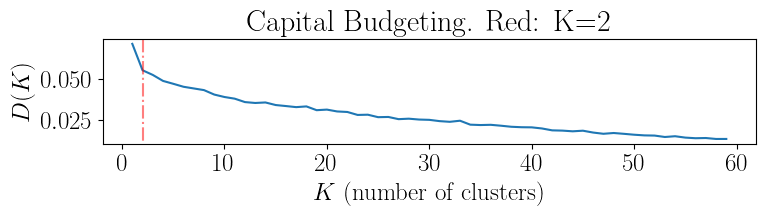

In [2]:
K_nums = [1, 2, 3, 10, 30, 60, 120]
N_tot = 120
m = 20
d = (np.vstack([np.random.uniform(0.005*i, 0.02 *
      (i+1), int(N_tot/2)) for i in range(m)])).T
d2 = (np.vstack([np.random.uniform(0.01*i, 0.025 *
      (i+1), int(N_tot/2)) for i in range(m)])).T
dat_val = np.vstack([d, d2])
d = (np.vstack([np.random.uniform(0.005*i, 0.02 *
      (i+1), int(N_tot/2)) for i in range(m)])).T
d2 = (np.vstack([np.random.uniform(0.01*i, 0.025 *
      (i+1), int(N_tot/2)) for i in range(m)])).T
dat_eval = np.vstack([d, d2])
vals_cap = []
for K in np.arange(1,60):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(dat_val)
    weights = np.bincount(kmeans.labels_) / N_tot
    vals_cap.append(kmeans.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.plot(np.arange(1,60),vals_cap)
plt.axvline(x=2, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
# plt.yscale("log")
plt.title("Capital Budgeting. Red: K=2")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.tight_layout()
plt.savefig("capital_k.pdf")

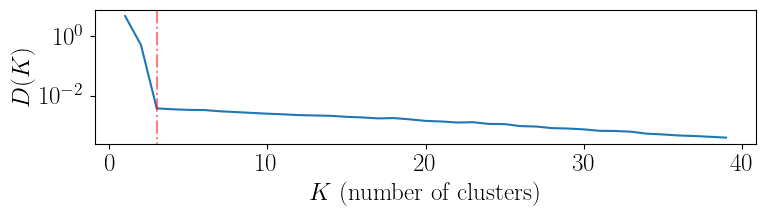

In [68]:
d = data_modes(90, 30, [1, 3, 7])
vals = []
for K in np.arange(1,40):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(d)
    weights = np.bincount(kmeans.labels_) / N_tot
    vals.append(kmeans.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.plot(np.arange(1,40),vals)
plt.axvline(x=3, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
plt.yscale("log")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.tight_layout()
plt.savefig("log_k.pdf")

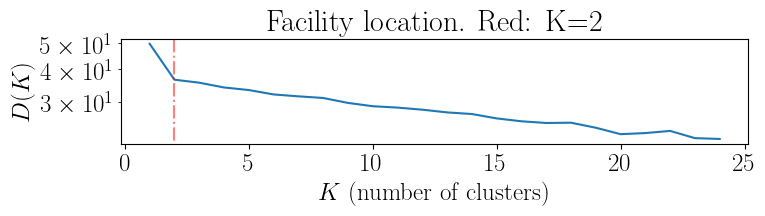

In [3]:
def generate_facility_demands(N, m, R):
    """Generate uncertain demand
    Parameters:
     ----------
    N: int
        Number of data samples
    m: int
        Number of facilities
    R: int
        Number of sets of data samples
    Returns:
    -------
    d_train: vector
        Demand vector
    """

    dat = np.random.normal(4,0.8,(N,m,R))
    dat2 = np.random.normal(3,0.9,(N,m,R))
    dat = np.vstack([dat, dat2])
    dat = np.minimum(dat,6)
    dat = np.maximum(dat,1)
    # d_train = np.random.uniform(1, 6, (N, m, R))
    return dat


N_tot = 50
M = 10
R = 10       # Total times we repeat experiment to estimate final probabilty
n = 5  # number of facilities
m = 25  # number of locations
Data = generate_facility_demands(N_tot, m,1)
vals_fac = []
for K in np.arange(1,25):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(Data[:,:,0])
    weights = np.bincount(kmeans.labels_) / N_tot
    vals_fac.append(kmeans.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.plot(np.arange(1,25),vals_fac)
plt.axvline(x=2, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
plt.title("Facility location. Red: K=2")
plt.yscale("log")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.tight_layout()
plt.savefig("facility_k.pdf")

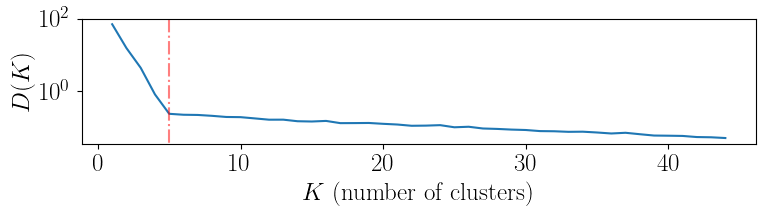

In [69]:
def normal_returns_scaled(N, m, scale):
    """Creates scaled data
    Parameters:
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Scales: float
        Multiplier for a single mode
    Returns:
    -------
    d: matrix
        Scaled data with a single mode
    """
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())


def data_modes(N, m, scales):
    """Creates data scaled by given multipliers
    Parameters:
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Scales: vector
        Multipliers of different modes
    Returns:
    -------
    d: matrix
        Scaled data with all modes
    """
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = normal_returns_scaled(weights, m, scales[i])
    return d[0:N, :]
N_tot = 90
m = 10
d = data_modes(N_tot, m, [1, 5, 15, 25, 40])
vals = []
for K in np.arange(1,45):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(d)
    weights = np.bincount(kmeans.labels_) / N_tot
    vals.append(kmeans.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.plot(np.arange(1,45),vals)
plt.axvline(x=5, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
plt.yscale("log")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.tight_layout()
plt.savefig("quad_k.pdf")

In [4]:
synthetic_returns = pd.read_csv('sp500_synthetic_returns.csv').to_numpy()[:, 1:]

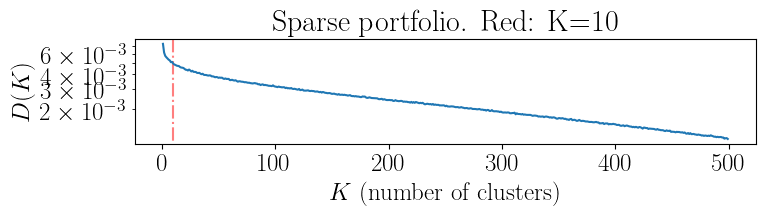

In [5]:
from sklearn.model_selection import train_test_split
N_tot = 1000
M = 15
R = 10         # Total times we repeat experiment
m = 30
dat, dateval = train_test_split(
        synthetic_returns[:, :m], train_size=10000, test_size=10000, random_state=7)
data = dat[(N_tot*0):(N_tot*(0+1))]
vals_port = []
for K in np.arange(1,500):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(data)
    weights = np.bincount(kmeans.labels_) / N_tot
    vals_port.append(kmeans.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.axvline(x=10, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
plt.plot(np.arange(1,500),vals_port)
plt.title("Sparse portfolio. Red: K=10")
plt.yscale("log")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.tight_layout()
plt.savefig("port_k.pdf")

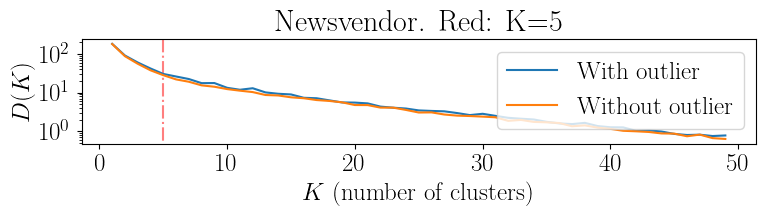

In [6]:
N_tot = 100
m = 30
def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.3,-0.1],[-0.1,0.2]])
    mu = np.array((3,2.8))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    d_train = np.minimum(d_train,40)
    return d_train
dat2 = gen_demand_intro(100,0)
dat = gen_demand_intro(100,0)[:-1]
# dat = np.vstack([dat,np.array([30,30])])
dat = np.vstack([dat,np.array([0,0])])
vals = []
vals2 = []
for K in np.arange(1,50):
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(dat)
    weights = np.bincount(kmeans.labels_) / N_tot
    vals.append(kmeans.inertia_/N_tot)
    kmeans2 = KMeans(n_clusters=K, n_init='auto').fit(dat2)
    weights2 = np.bincount(kmeans2.labels_) / N_tot
    vals2.append(kmeans2.inertia_/N_tot)
plt.figure(figsize = (8,2.5))
plt.axvline(x=5, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
plt.plot(np.arange(1,50),vals, label = "With outlier")
plt.plot(np.arange(1,50),vals2, label = "Without outlier")
plt.title("Newsvendor. Red: K=5")
plt.yscale("log")
plt.xlabel("$K$ (number of clusters)")
plt.ylabel("$D(K)$")
plt.legend()
plt.tight_layout()
plt.savefig("news_k.pdf")

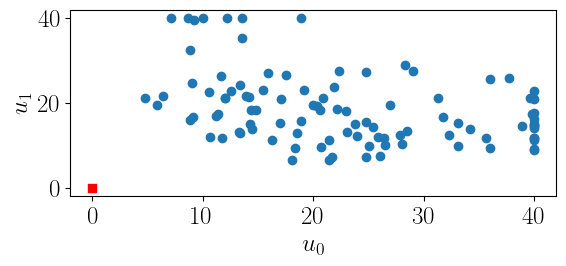

In [21]:
plt.figure(figsize = (6,3))
dat = gen_demand_intro(100,0)
plt.scatter(dat[:,0], dat[:,1],label = "Data points")
plt.scatter(0,0,color = "red", label = "Extreme point", marker = 's')
# plt.scatter(30,30,color = "red", marker = 's')
plt.xlabel("$u_0$")
plt.ylabel("$u_1$")
# plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("news_outliers.pdf")
plt.show()

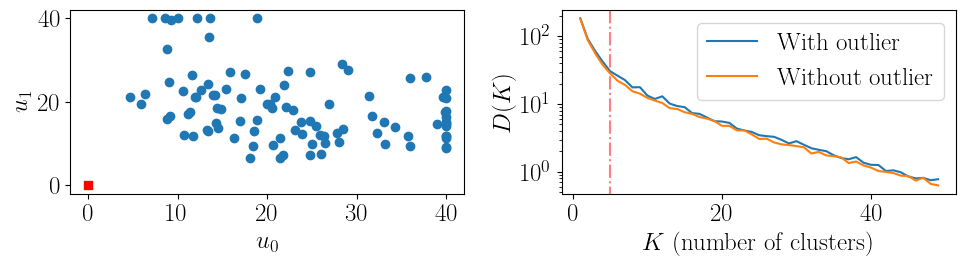

In [10]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 3))
ax1.axvline(x=5, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
ax1.plot(np.arange(1,50),vals, label = "With outlier")
ax1.plot(np.arange(1,50),vals2, label = "Without outlier")
ax1.set_yscale("log")
ax1.set_xlabel("$K$ (number of clusters)")
ax1.set_ylabel("$D(K)$")
ax1.legend()
ax2.scatter(dat[:,0], dat[:,1],label = "Data points")
ax2.scatter(0,0,color = "red", label = "Extreme point", marker = 's')
# plt.scatter(30,30,color = "red", marker = 's')
ax2.set_xlabel("$u_0$")
ax2.set_ylabel("$u_1$")
# plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("news_comb.pdf")

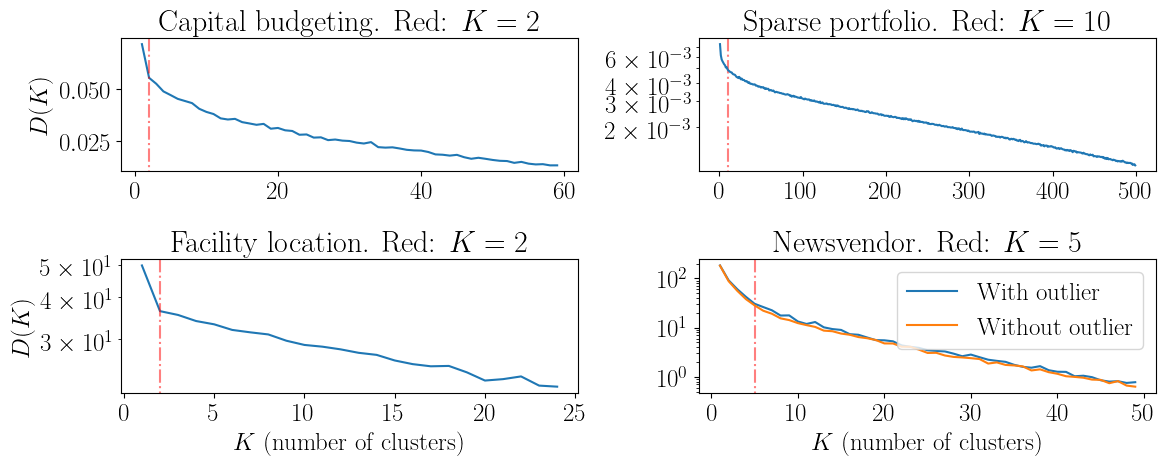

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
ax1.plot(np.arange(1,60),vals_cap)
ax1.axvline(x=2, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
# plt.yscale("log")
ax1.set_title("Capital budgeting. Red: $K=2$")
# ax1.set_xlabel("$K$ (number of clusters)")
ax1.set_ylabel("$D(K)$")

ax2.axvline(x=10, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
ax2.plot(np.arange(1,500),vals_port)
ax2.set_title("Sparse portfolio. Red: $K=10$")
ax2.set_yscale("log")
# ax2.set_xlabel("$K$ (number of clusters)")
# ax2.set_ylabel("$D(K)$")

ax3.plot(np.arange(1,25),vals_fac)
ax3.axvline(x=2, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
ax3.set_title("Facility location. Red: $K=2$")
ax3.set_yscale("log")
ax3.set_xlabel("$K$ (number of clusters)")
ax3.set_ylabel("$D(K)$")

ax4.axvline(x=5, ymax = 0, ymin = 1, color = "red", linestyle = '-.', alpha = 0.5)
ax4.plot(np.arange(1,50),vals, label = "With outlier")
ax4.plot(np.arange(1,50),vals2, label = "Without outlier")
ax4.set_title("Newsvendor. Red: $K=5$")
ax4.set_yscale("log")
ax4.set_xlabel("$K$ (number of clusters)")
# ax4.set_ylabel("$D(K)$")
ax4.legend()
plt.tight_layout()
plt.savefig("kbot_comb.pdf")